# Algorithmic Trading Strategy Challenge

Name: Kyle Savino

In [31]:
# Name: Kyle Savino
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf



In [32]:
#The given date range is 1/1/22 to 12/31/24. I am assuming this is a typo, since we're still in 2024? In light of this, I am putting my time range as 
# 1-1-22 -> 12-31-23
date_range = pd.date_range(start="2022-01-01", end="2023-12-31")
dateList = [date.strftime("%Y-%m-%d") for date in date_range]

class Stock:
    def __init__(self, ticker):
        self.quantity = 0
        self.ticker = ticker
        self.price = [0] * len(dateList)
        i = -1
        self.data = yf.download(ticker, start = dateList[0], end = dateList[len(dateList)-1])
        # Downloading of stock info/prices is all done here so we only have to do it once. Makes the simulation run faster.
        self.mean = 0
        self.marketPrices = []
        self.predicted_probability = []
        for day in dateList:
            '''Initializes a self.price list for the stock object which holds its closing price for every day in the time period.
            If the market is closed on a given day, the stockPrice for that day is 0, so we know to pass over it during the simulation.'''
            i +=1
            try:
                stockPrice = self.data.loc[day]["Close"]
            except (IndexError, ValueError, KeyError):
                continue
            self.price[i] = stockPrice
            if stockPrice != 0:
                self.marketPrices.append(stockPrice)

    def getValue(self, day):
        return self.quantity * self.price[day]

    def rateOfChange(self, startingDay, period):
        '''Returns the signed rate of change for the price of the stock over a given time period'''
        delta = 0
        daysReached = 0
        while period > 0 and startingDay > 0:
            while self.price[startingDay] == 0:
                startingDay -= 1
                if startingDay <= 0:
                    return delta/daysReached
            nextNonZeroDay = startingDay - 1
            if nextNonZeroDay < 0:
                return delta/daysReached
            while self.price[nextNonZeroDay] == 0:
                nextNonZeroDay -= 1
                if nextNonZeroDay < 0:
                    return delta/daysReached
            delta += self.price[startingDay] - self.price[nextNonZeroDay]
            daysReached += 1
            period -=1
            startingDay -= 1
        return delta/daysReached

    def findLastMarketDay(self, i):
        '''Returns the most recent day at an index which was the market was open'''
        while self.price[i] == 0:
            i -= 1
        return i

    def absoluteRateOfChange(self, startingDay, period):
        '''Returns the absolute value of the rate of change, used to measure volatility
        eg: a high number means that the price of this stock is jumping around a lot, but direction is unknown'''
        delta = 0
        daysReached = 0
        while period > 0 and startingDay > 0:
            while self.price[startingDay] == 0:
                if startingDay <= 0:
                    return delta
                startingDay -= 1
            nextNonZeroDay = startingDay - 1
            if nextNonZeroDay < 0:
                return delta
            while self.price[nextNonZeroDay] == 0:
                nextNonZeroDay -= 1
                if nextNonZeroDay < 0:
                    return delta
            if self.price[startingDay] - self.price[nextNonZeroDay] < 0:
                delta += self.price[nextNonZeroDay] - self.price[startingDay]
                daysReached += 1
                period -=1
                startingDay -= 1
            else:
                delta += self.price[startingDay] - self.price[nextNonZeroDay]
                daysReached += 1
                period -= 1
                startingDay -= 1
        return delta/daysReached



In [33]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import models
from sklearn.model_selection import train_test_split

#Below stocks are the ones I will trade during the simulation.
stock1 = Stock("AAPL")
stock2 = Stock("JNJ")
stock3 = Stock("TSLA")
stock4 = Stock("PFE")   
stocks_used = [stock1, stock2, stock3, stock4]

#Below stocks are used for the Buy and Hold. These will be left untouched during the simulation.
stock11 = Stock("AAPL")
stock12 = Stock("JNJ")
stock13 = Stock("TSLA")
stock14 = Stock("PFE")   

def preprocess_data(training_days: int, stock):
    y = [0] * training_days
    Three_day_rate_of_changes = [0] * training_days
    Five_day_rate_of_changes = [0] * training_days
    for day_index in range(0, training_days-1):
        if day_index >= 3:
            Three_day_rate_of_changes[day_index] = stock.rateOfChange(day_index, 3)
        if day_index >= 5:
            Five_day_rate_of_changes[day_index] = stock.rateOfChange(day_index, 5)

        # If the stock will increase tomorrow, mark the current day with a positive classification (1). This is so we can train the model.
        if stock.marketPrices[day_index] <= stock.marketPrices[day_index+1]:
            y[day_index] = 1
        else:
            y[day_index] = 0
    X = np.array([[price, three_day_roc, five_day_roc] for price, three_day_roc, five_day_roc in zip(stock1.marketPrices, Three_day_rate_of_changes, Five_day_rate_of_changes)])
    y = np.array(y[:training_days])
    return X, y


def create_nn(X, X_train, X_test, y_train, y_test, stock_name):
    # Creates and trains a model, returns a list with a prediction for if a stock will rise or fall tomorrow, for each day
    # The model could be vastly improved with more data and further tuning. Unfortunately, I do not currently have the time or resources to perfect this.
    # For now, this will have to do.
    model= models.Sequential()
    model.add(keras.layers.Dense(units = 230, activation = 'relu'))
    model.add(keras.layers.Dense(units = 150, activation = 'relu'))
    model.add(keras.layers.Dense(units = 1, activation = 'sigmoid'))
    learning_rate = 0.001
    model.compile(
        optimizer=keras.optimizers.legacy.Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=['accuracy'],   
        )
    model.fit(X_train, y_train, epochs=100, verbose=0)
    # test_accuracy = model.evaluate(X_test, y_test)
    # print("Prediction Accuracy for  ", stock_name, " is:", test_accuracy[1])
    probability_predictions = model.predict(X)
    avg_prob = sum(probability_predictions)/len(probability_predictions)
    binary_predictions = [1 if prob > avg_prob else 0 for prob in probability_predictions]  
    return binary_predictions

for stock in stocks_used:
    X, y = preprocess_data(len(stock.marketPrices), stock)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    predictions = create_nn(X, X_train, X_test, y_train, y_test, stock.ticker)
    stock.predicted_probability = predictions
    #Now, each stock has a prediction for if the price will rise tomorrow, stored in its respective self.predicted_probability



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


16/16 [==============================] - 0s 400us/step


## Strategy Implementation

In [34]:
'''Synposis: 
Primary Strategies: Trend following, Mean Reversion, along with a Neural Network which is trained to predict if a stock will rise or drop tomorrow.

Details:
At each day, starting at 3 days after the beginning of the time period, the algorithm checks several values (stock's past 1 day performance, stocks past 3 days performance).
I aim to buy stocks that are recently trending down (but stopped dropping), and sell stocks that have recently trended up (but growth has stopped). 
Additionally, as shown above, every day the deep learning model predicts whether the given stock will rise or drop on the following day. 
I only sell or buy if both my algorithm (the Trend Following and Mean Reversion) AND the Neural Network agree on the same decision.'''

#AAPL, JNJ, TSLA, PFE 
daysReached = -1  
'''Days reached starts at -1 so that it lines up with the predictions in each stock class.'''
currentCash = 100000
daysBought = [0] * len(dateList) # Updated with 1 if a trade is made that day
daysSold = [0] * len(dateList)
portfolioValue = [0] * len(dateList)

# portfolio is intialized with 1/4 of money equally divided in each 4 stock
stock1.quantity = 25000//stock1.price[2]
stock2.quantity = 25000//stock2.price[2]
stock3.quantity = 25000 // stock3.price[2]
stock4.quantity = 25000 // stock4.price[2]

   
stock11.quantity = 25000//stock11.price[2]
stock12.quantity = 25000//stock12.price[2]
stock13.quantity = 25000 // stock13.price[2]
stock14.quantity = 25000 // stock14.price[2]
BaHcurrentCash = 100000 - (stock11.getValue(2) + stock12.getValue(2) + stock13.getValue(2) + stock14.getValue(2))
buyAndHold = [0] * len(dateList)

currentCash -= stock1.getValue(2) + stock2.getValue(2) + stock3.getValue(2) + stock4.getValue(2)

portfolio_returns_daily = []
bah_returns_daily = []


# Intialization is done - now the algorithm runs.
for i in range(len(dateList)):
        market_day = False
        if stock1.price[i] != 0:
            market_day = True
            daysReached += 1  #only increases if the market is open on the current day. Important for checking with the predictations from the neural network
        if stock1.price[i] == 0 or i == 0 or i == 1 or i == 2 or i == 3:
            '''Skipping first few days because we must be able to check the prior 3 days movement
           of the stock to decide on our actions'''
            if i == 0 or i == 1 or i == 3:
                portfolioValue[i] = 100000
                buyAndHold[i] = 100000
                continue
            else:
                '''If the market is closed on the current day, we set the portfolio value to its value on the close of the last open day'''
                lastDay = stock1.findLastMarketDay(i)
                portfolioValue[i] = (stock1.getValue(lastDay) + stock2.getValue(lastDay)
                + stock3.getValue(lastDay) + stock4.getValue(lastDay) + currentCash)
                buyAndHold[i] = (stock11.getValue(lastDay) + stock12.getValue(lastDay)
                + stock13.getValue(lastDay) + stock14.getValue(lastDay) + BaHcurrentCash)
                continue
        
        stock1.mean = sum(stock1.marketPrices[0: daysReached])/daysReached
        stock2.mean = sum(stock2.marketPrices[0: daysReached])/daysReached
        stock3.mean = sum(stock3.marketPrices[0: daysReached])/daysReached
        stock4.mean = sum(stock4.marketPrices[0: daysReached])/daysReached

        buyAndHold[i] = (stock11.getValue(i) + stock12.getValue(i) + stock13.getValue(i) + stock14.getValue(i) + BaHcurrentCash)
        portfolioValue[i] = (stock1.getValue(i) + stock2.getValue(i) + stock3.getValue(i) + stock4.getValue(i) + currentCash)

        if market_day:
            # Used to calculate sharpe ratio later
            portfolio_returns_daily.append((portfolioValue[i] - portfolioValue[i - 1])/portfolioValue[i - 1])
            bah_returns_daily.append((buyAndHold[i] - buyAndHold[i-1])/buyAndHold[i-1])

            

        '''Calculating immediate (1 day) and general (3 day) rate of change to determine market trends'''
        stockOne3DayDelta = stock1.rateOfChange(i, 3)
        stockTwo3DayDelta = stock2.rateOfChange(i, 3)
        stockThree3DayDelta = stock3.rateOfChange(i, 3)
        stockFour3DayDelta = stock4.rateOfChange(i, 3)
        stockOne1DayDelta = stock1.rateOfChange(i, 1)
        stockTwo1DayDelta = stock2.rateOfChange(i, 1)
        stockThree1DayDelta = stock3.rateOfChange(i, 1)
        stockFour1DayDelta = stock4.rateOfChange(i, 1)
       
        '''If a stock value has dropped more than 5% in one day, then sell all of it. Despite this happening very rarely,
        this condition is here to prevent any disasters that could occur since the portfolio often has most of its value in one stock
        at a time, and a sudden drop in that stock could be catastrophic. This is the only decision that doesn't require approval from the
        neural network - again, because this is an absolute last resort failsafe.'''
        if stockOne1DayDelta/stock1.price[i] <= -0.05:
            currentCash += stock1.quantity * stock1.price[i]
            stock1.quantity = 0
            daysSold[i] = 1
        if stockTwo1DayDelta/stock2.price[i] <= -0.05:
            currentCash += stock2.quantity * stock2.price[i]
            stock2.quantity = 0
            daysSold[i] = 1
        if stockThree1DayDelta/stock3.price[i] <= -0.05:
            currentCash += stock3.quantity * stock3.price[i]
            stock3.quantity = 0
            daysSold[i] = 1
        if stockFour1DayDelta/stock4.price[i] <= -0.05:
            currentCash += stock4.quantity * stock4.price[i]
            stock4.quantity = 0
            daysSold[i] = 1

        '''If the stock value has been trending upwards the past 3 days, but stopped rising today or
        started to drop, and if the neural network has predicted the stock to drop tomorrow, then sell.'''
        if stock1.rateOfChange(i, 1) <= 0 and stock1.rateOfChange(i, 3) > 0 and stock1.predicted_probability[daysReached] == 0:
            currentCash += stock1.quantity * stock1.price[i]
            stock1.quantity = 0
            daysSold[i] = 1
        if stock2.rateOfChange(i, 1) <= 0 and stock2.rateOfChange(i, 3) > 0 and stock2.predicted_probability[daysReached] == 0:
            currentCash += stock2.quantity * stock2.price[i]
            stock2.quantity = 0
            daysSold[i] = 1
        if stock3.rateOfChange(i, 1) <= 0 and stock3.rateOfChange(i, 3) > 0 and stock3.predicted_probability[daysReached] == 0:
            currentCash += stock3.quantity * stock3.price[i]
            stock3.quantity = 0
            daysSold[i] = 1
        if stock4.rateOfChange(i, 1) <= 0 and stock4.rateOfChange(i, 3) > 0 and stock4.predicted_probability[daysReached] == 0:
            currentCash += stock4.quantity * stock4.price[i]
            stock4.quantity = 0
            daysSold[i] = 1

        '''If a stock has been trending down the past 3 days, but stopped going down and/or
        started to go up, and if the neural network predicts that the stock will go up tomorrow, then buy.
        
        This condition is weighted by percentages, so if stock1 is 20% below its mean and stock2 is below 10% of its mean,
        the algorithm will prioritize buying stock1 instead of stock2, regardless of how much the stocks themselves are worth.'''
        temp = [None, None, None, None]
        if stock1.rateOfChange(i, 1) >= 0 and stock1.rateOfChange(i, 3) < 0 and stock1.predicted_probability[daysReached] == 1:
            temp[0] = (stock1.price[i] - stock1.mean)/stock1.mean
        if stock2.rateOfChange(i, 1) >= 0 and stock2.rateOfChange(i, 3) < 0 and stock2.predicted_probability[daysReached] == 1:
            temp[1] = (stock2.price[i] - stock2.mean)/stock2.mean
        if stock3.rateOfChange(i, 1) >= 0 and stock3.rateOfChange(i, 3) < 0 and stock3.predicted_probability[daysReached] == 1:
            temp[2] = (stock3.price[i] - stock3.mean)/stock3.mean
        if stock4.rateOfChange(i, 1) >= 0 and stock4.rateOfChange(i, 3) < 0 and stock4.predicted_probability[daysReached] == 1:
            temp[3] = (stock4.price[i] - stock4.mean)/stock4.mean
        StockValues = []
        for value in temp:
            if value is not None:
                StockValues.append(value)
        if len(StockValues) != 0:
            daysBought[i] = 1
            stockToBuy = max(StockValues)
            if currentCash <= 25000:
                daysSold[i] = 1
                '''If we don't have much cash, then whichever stock has risen the most over the past 3 days, 
                    sell it and use that cash to buy the stock which I am predicting to go up. I could also choose
                    to sell the stock which is currently most above its mean, but for this algorithm I have decided
                    to sell the one which has risen most recently, anticipating that it will fall shortly.'''
                if stockToBuy == temp[0]:
                    bestPerfomer = max([stockTwo3DayDelta, stockThree3DayDelta, stockFour3DayDelta])
                    index = [stockTwo3DayDelta, stockThree3DayDelta, stockFour3DayDelta].index(bestPerfomer)
                    if index == 0:
                        currentCash += stock2.price[i] * stock2.quantity
                        stock2.quantity = 0
                    if index == 1:
                        currentCash += stock3.price[i] * stock3.quantity
                        stock3.quantity = 0
                    if index == 2:
                        currentCash += stock4.price[i] * stock4.quantity
                        stock4.quantity = 0
                if stockToBuy == temp[1]:
                    bestPerfomer = max([stockOne3DayDelta, stockThree3DayDelta, stockFour3DayDelta])
                    index = [stockOne3DayDelta, stockThree3DayDelta, stockFour3DayDelta].index(bestPerfomer)
                    if index == 0:
                        currentCash += stock1.price[i] * stock1.quantity
                        stock1.quantity = 0
                    if index == 1:
                        currentCash += stock3.price[i] * stock3.quantity
                        stock3.quantity = 0
                    if index == 2:
                        currentCash += stock4.price[i] * stock4.quantity
                        stock4.quantity = 0
                if stockToBuy == temp[2]:
                    bestPerfomer = max([stockOne3DayDelta, stockTwo3DayDelta, stockFour3DayDelta])
                    index = [stockOne3DayDelta, stockTwo3DayDelta, stockFour3DayDelta].index(bestPerfomer)
                    if index == 0:
                        currentCash += stock1.price[i] * stock1.quantity
                        stock1.quantity = 0
                    if index == 1:
                        currentCash += stock2.price[i] * stock2.quantity
                        stock2.quantity = 0
                    if index == 2:
                        currentCash += stock4.price[i] * stock4.quantity
                        stock4.quantity = 0
                if stockToBuy == temp[3]:
                    bestPerfomer = max([stockOne3DayDelta, stockTwo3DayDelta, stockThree3DayDelta])
                    index = [stockOne3DayDelta, stockTwo3DayDelta, stockThree3DayDelta].index(bestPerfomer)
                    if index == 0:
                        currentCash += stock1.price[i] * stock1.quantity
                        stock1.quantity = 0
                    if index == 1:
                        currentCash += stock2.price[i] * stock2.quantity
                        stock2.quantity = 0
                    if index == 2:
                        currentCash += stock3.price[i] * stock3.quantity
                        stock3.quantity = 0
            if stockToBuy == temp[0]:
                quantity = currentCash // stock1.price[i]
                currentCash -= quantity * stock1.price[i]
                stock1.quantity += quantity
            if stockToBuy == temp[1]:
                quantity = currentCash // stock2.price[i]
                currentCash -= quantity * stock2.price[i]
                stock2.quantity += quantity
            if stockToBuy == temp[2]:
                quantity = currentCash // stock3.price[i]
                currentCash -= quantity * stock3.price[i]
                stock3.quantity += quantity
            if stockToBuy == temp[3]:
                quantity = currentCash // stock4.price[i]
                currentCash -= quantity * stock4.price[i]
                stock4.quantity += quantity



## Performance Visualization

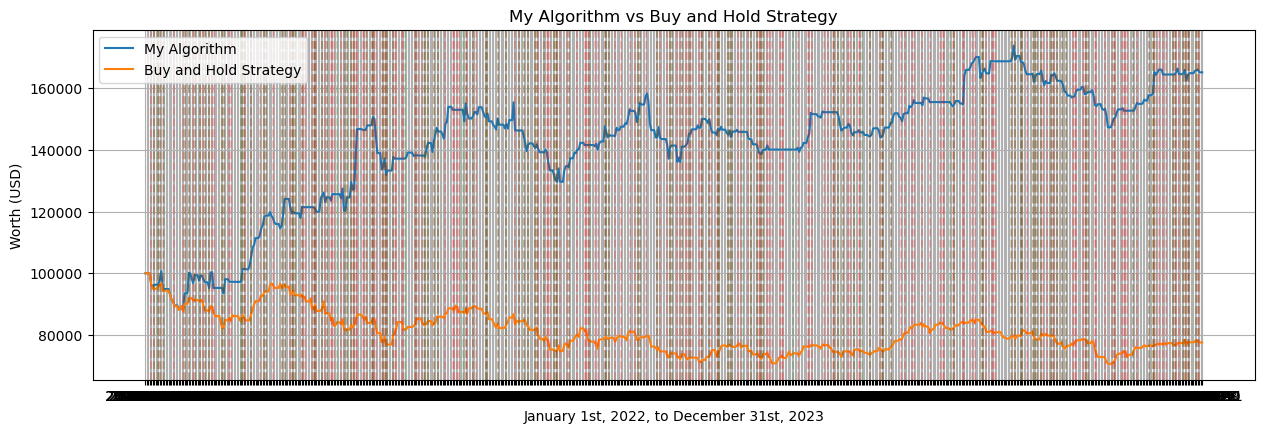

In [35]:
'''The red lines are for each day in which a stock in the portfolio was sold'''
'''The green lines are for each day a stock in the portfolio was bought
The brown lines are when a stock in the portfolio was both sold and bought that day'''
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.plot(dateList, portfolioValue, label="My Algorithm")
plt.plot(dateList, buyAndHold, label = "Buy and Hold Strategy")
plt.title("My Algorithm vs Buy and Hold Strategy")
plt.xlabel("January 1st, 2022, to December 31st, 2023")
plt.ylabel("Worth (USD)")
plt.grid(True)
plt.legend()



for i in range(len(dateList)):
     if daysSold[i] == 1:
        plt.axvline(x=i, color='r', linestyle='--', alpha = 0.2)
     if daysBought[i] == 1:
        plt.axvline(x=i, color='g', linestyle='--', alpha = 0.2)


## Compare the strategy and buy and hold's sharpe ratio

In [36]:
counter = 0
avg = 0
BAHavg = 0

for i in range(len(dateList)):
     avg += portfolioValue[i]
     BAHavg += buyAndHold[i]
     if daysBought[i] == 1 or daysSold[i] == 1:
        counter += 1
         
#annual_portfolio_return = ((1 + portfolio_return) ** (1 / 2)) - 1
        


risk_free_rate = 4.13   # I am using 4.13 as thats the current 10 year treasury rate


annual_portfolio_return = (sum(portfolio_returns_daily)/2) *100 #divide by 2 since my time period was 2 years
excess_return = annual_portfolio_return - risk_free_rate
portfolio_standard_deviation = np.std(portfolio_returns_daily) * daysReached/2
sharpe_ratio = excess_return / portfolio_standard_deviation
print("Sharpe ratio of my algorithm is ", sharpe_ratio)

annual_bah_return = (sum(bah_returns_daily)/2)*100
excess_return = annual_bah_return - risk_free_rate
bah_standard_deviation = np.std(bah_returns_daily) * daysReached/2
sharpe_ratio = excess_return / bah_standard_deviation
print("Sharpe ratio of buy and hold is ", sharpe_ratio)


print("Summary: Stocks were traded on",counter,"days, out of",daysReached,"total market days.")

print("The final value of my portfolio was " , portfolioValue[-1])
print("The average value of my portfolio over the time period was ", avg / len(portfolioValue))

print("The final value of Buy and Hold strategy was ", buyAndHold[-1])
print("The average value of the buy and hold portfolio was ", BAHavg / len(buyAndHold) )


Sharpe ratio of my algorithm is  6.0909897341598835
Sharpe ratio of buy and hold is  -4.494390072813432
Summary: Stocks were traded on 276 days, out of 500 total market days.
The final value of my portfolio was  165064.2244873047
The average value of my portfolio over the time period was  141867.1246429391
The final value of Buy and Hold strategy was  77619.2885131836
The average value of the buy and hold portfolio was  81018.88257102967
